In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch import nn

# 房价预测任务
利用深度学习算法解决一个实际问题的步骤如下:
1. 明确问题和任务
2. 数据获取和数据初步探索
3. 数据预处理
4. 特征工程
5. 模型选择和训练
6. 模型评估
7. 模型融合
8. 模型验证

## 明确问题和任务
任务: 根据各种特征来预测房价, 属于回归任务

## 数据获取与初步探索
需要使用的数据集在 `./data` 中, 相关的数据集如下:
- `train.csv`: 训练集
- `test.csv`: 测试集
- `sample_submission.csv`: 使用一个简单的线性模型进行预测的结果, 用于对比

In [55]:
# 1. 读取数据集
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [56]:
# 2. 简单看一下数据
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [57]:
# 提取特征
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2008,WD,Normal
1,20,RL,80.0,9600,2007,WD,Normal
2,60,RL,68.0,11250,2008,WD,Normal
3,70,RL,60.0,9550,2006,WD,Abnorml


## 数据预处理
这里数据预处理主要是处理缺失值(这里采用使用平均值代替) ; 同时需要为了把所有特征放在一个共同的尺度上, 可以通过把特征重新缩放到零均值和单位方差来标准化数据:
$$
x \leftarrow \frac {x - \mu}{\sigma}
$$
进行替换之后可以实现 $E[\frac {x - \mu}{\sigma}] = 0$ 以及 $E[(x - \mu)^2] = {\sigma}^2$, 这样可以把数据都放在一定范围中, ~~缓解梯度消失或者梯度爆炸等问题(只是一个方面)~~, **核心目的是消除特征尺度差异、确保模型公平学习各特征的贡献(如果不这样可能导致模型参数更新偏向大尺度特征)**

In [58]:
# 数据预处理过程
# 1. 标准化数字特征
# 注意布尔型数组的使用  a = matrix[cond(matrix)].index 提取索引, matrix[a] 操作特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: ((x - x.mean())/x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 缺失值填 0

In [59]:
all_features.iloc[0:4, [0, 1, 2, 3]]

,MSSubClass,MSZoning,LotFrontage,LotArea
0,0.067320,RL,-0.184443,-0.217841
1,-0.873466,RL,0.458096,-0.072032
2,0.067320,RL,-0.055935,0.137173
3,0.302516,RL,-0.398622,-0.078371


In [68]:
# 2. 处理其他缺失值, 注意 get_dummies 函数的作用
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features = all_features.astype('float32')
all_features.shape

(2919, 330)

In [69]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 特征工程
> 我的理解特征工程就是对于特征进行一系列操作, 从而达到提升模型性能的效果

同时特征工程还包含如下几个部分的操作:
1. 数据清洗与预处理: 缺失值处理、异常值处理、数据标准化/归一化
2. 特征构建与衍生: 组合特征(月份 + 年份等)、统计特征(计算分组之后的均值等)、文本特征提取(`Word2Vec`等), 时间特征处理
3. 特征转换以及编码: `One-hot`编码(将类别转换为二进制数据), 标签编码(类别映射为整数), 目标编码(用目标变量的统计值替换类别)

## 模型选择和训练
这里可以选择时用一个带有平方损失的线性模型, 这里对预测值和真实值去对于之后带入平方损失函数(此时关心相对数量, 而不是绝对数量):
$$
\sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log y_i - \log \hat{y}_i \right)^2}
$$

In [135]:
train_features.shape 

torch.Size([1460, 330])

In [208]:
# 1. 网络结构
loss = nn.MSELoss()
in_features = train_features.shape[1] # 特征数
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [209]:
# 2. 评估使用的损失函数, 但是预测的是房价, 所以预测使用平方损失函数
def log_rmse(net, features, labels):
    clipped_pred = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_pred), torch.log(labels)))
    return rmse.item()

In [210]:
# 3. 数据集封装
class ArrayDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self,idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label
def load_from_array(features, labels, batch_size=256):
    return DataLoader(ArrayDataset(features, labels), shuffle=True, batch_size=batch_size)

In [211]:
# 4. 训练函数
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, lr, weight_decay, batch_size):
    """
    @Description: 一个通用的模型训练函数
    net: 待训练模型
    train_features: 训练集特征
    train_labels:   训练集标签
    test_features:  测试集特征
    test_labels:    测试集标签
    num_epochs:     训练轮数
    lr:             学习率
    weight_decay:   正则化系数
    batch_size:     批量
    """
    train_ls, test_ls = [], [] # 记录训练集上的损失和测试集上的损失
    train_iter = load_from_array(train_features, train_labels)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None: # == -> is != -> is not
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## 模型评估
这里使用 `K` 折交叉验证进行模型评估, 从而提高模型的泛化能力等: 把训练集分为 `K` 份, 其中 `1` 份作为验证集, 同时 `K - 1` 份作为训练集, 在训练集上训练并且在验证集上对于模型进行测试

In [212]:
def get_k_fold_data(k, i, X, y):
    """
    @Description: 训练集划分为 K 份, 其中第 i 份数组作为验证集, 其他作为训练集
    """
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j + 1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [199]:
def draw(num_epochs, train_ls, valid_ls):
    if len(train_ls) > 0:
        plt.plot(list(range(1, num_epochs + 1)), train_ls, label='train')
    if len(valid_ls) > 0:
        plt.plot(list(range(1, num_epochs + 1)), valid_ls, label='valid')
    plt.xlabel('epoch')
    plt.ylabel('rmse')
    plt.yscale('log')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    
def k_fold(k, X_train, y_train, num_epochs, lr, weight_decray, 
          batch_size):
    """
    K折交叉验证
    """
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, lr, 
                                   weight_decray, batch_size)
        train_l_sum += train_ls[-1] # 只记录最后一次的 loss
        valid_l_sum += valid_ls[-1] 
        print(f'折{i + 1}, 训练log rmse {float(valid_ls[-1]):f}, 验证log rmse {float(train_ls[-1]):f}')
        if i == k - 1:
            draw(num_epochs, train_ls, valid_ls) 
    return train_l_sum / k, valid_l_sum / k  # 计算 k 此验证之后的平均损失

## 模型选择

折1, 训练log rmse 0.147645, 验证log rmse 0.130637
折2, 训练log rmse 0.149687, 验证log rmse 0.127975
折3, 训练log rmse 0.142895, 验证log rmse 0.126670
折4, 训练log rmse 0.141509, 验证log rmse 0.131688
折5, 训练log rmse 0.169793, 验证log rmse 0.123522


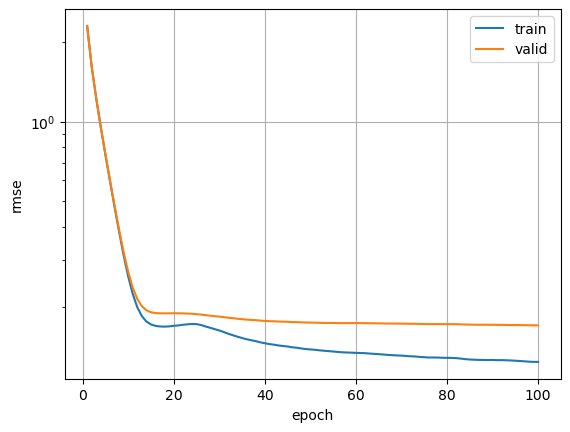

5-折验证: 平均训练log rmse: 0.128098, 平均验证log rmse: 0.150306


In [275]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 80 , 0 , 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 模型验证

In [276]:
# 预测并且提交结果
def train_and_pred(train_features, test_features, train_labels,
                  test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                        num_epochs, lr, weight_decay, batch_size)
    draw(num_epochs, train_ls, [])
    print(f'训练 log rmse:{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./data/submission.csv', index=False) # 不写入行标签 0, 1, 2...

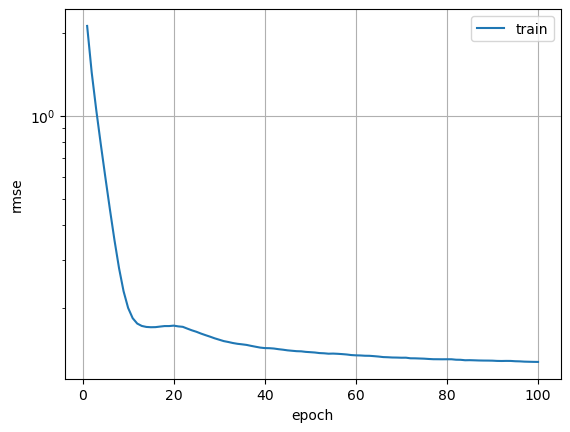

训练 log rmse:0.127955


In [277]:
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, lr, weight_decay, batch_size)

# 总结
根据我自己的理解, 总结利用深度学习算法解决一个实际问题的步骤如下:
1. 数据探索(探索数据类型, 数据方差均值等数字特征)
2. 数据预处理(处理异常值和缺失值, 数值类型特征归一化, 非数值类型特征可以使用 `One-Hot` 编码)
3. 特征工程(与前面不同的是, 这里是对于特征本身进行一系列的处理, 比如使用 `word2vec`)
4. 模型选择(选择合适的模型, 比如决策树、`MLP` 等)
5. 模型评估(对于选择的模型进行 `K` 折交叉验证获取全量训练, 对于超参数进行调整)
6. 模型融合(对于模型进行最终训练, 并且利用一定方法把时用到的模型预测的结果进行组合操作)
7. 模型验证(在测试集上评估模型效果)

## 注意事项
### 1. 数据探索
1. 这一个过程中最主要的就是读取文件操作, 可以使用 `pd.read_csv` 读取 `csv` 文件
2. 同时可以使用切片或者索引操作取出对应的行或者列, 使用 整数索引`iloc[行索引,列索引]` 可以根据整数切片或者索引来取出元素, 使用标签索引 `loc[行标签:列标签]` 可以根据标签来取索引
### 2. 数据预处理
1. 注意布尔型索引的使用, 比如需要取出所有包含数据为数值类型的索引: `arr.dtypes[arr.dtypes != 'object'].index`
2. 对于缺失值, 对于数值类型, 可以使用 `fillna`、`dropna`, 以及文本类型使用 `get_dummies`, 作用是把文类类型的变量转换为哑变量(使用`One-Hot`编码)
3. 同时对于数值类型需要急性数据归一化操作, 这里可以使用 `apply` 函数(对于 `Series` 的每一行进行操作, 对于 `DataFrame` 的每一列/行进行操作)或者对应的 `applymap` 函数(对于 `DataFrame` 中的每一个元素进行操作)
### 3. 特征工程
这里暂时没有特征工程, 展示不说
### 4. 模型选择
根据实际情况选择具体的模型
### 5. 模型评估
1. 初始化模型参数
2. 可以使用 `K` 折交叉验证来提高模型的泛化能力(对于数据量比较小的情况)
### 6. 模型融合
1. 对于模型进行最终训练
2. 把各种模型的输入通过一定方法组合起来
### 7. 模型验证
1. 在测试集上测试模型效果